In [1]:
import skfem as fem

In [2]:
from skfem.helpers import dot, grad  # helpers make forms look nice

In [3]:
@fem.BilinearForm
def a(u, v, _):
    return dot(grad(u), grad(v))

In [4]:
import numpy as np

In [5]:
@fem.LinearForm
def l(v, w):
    x, y = w.x  # global coordinates
    f = np.sin(np.pi * x) * np.sin(np.pi * y)
    return f * v

In [6]:
mesh = fem.MeshTri().refined(3)

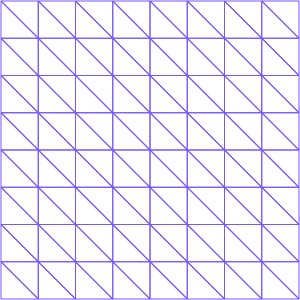

In [7]:
mesh

In [8]:
Vh = fem.Basis(mesh, fem.ElementTriP1())

In [9]:
Vh

<skfem CellBasis(MeshTri1, ElementTriP1) object>
  Number of elements: 128
  Number of DOFs: 81
  Size: 27648 B

In [10]:
A = a.assemble(Vh)
b = l.assemble(Vh)

In [11]:
A.shape

(81, 81)

In [12]:
b.shape

(81,)

In [13]:
D = Vh.get_dofs()

In [14]:
D

<skfem DofsView(MeshTri1, ElementTriP1) object>
  Number of nodal DOFs: 32 ['u']

In [15]:
x = fem.solve(*fem.condense(A, b, D=D))
x.shape

(81,)

In [16]:
@fem.Functional
def error(w):
    x, y = w.x
    uh = w['uh']
    u = np.sin(np.pi * x) * np.sin(np.pi * y) / (2. * np.pi ** 2)
    return (uh - u) ** 2

In [17]:
str(round(error.assemble(Vh, uh=Vh.interpolate(x)), 9))


'1.069e-06'

# Навье-Стокс

In [37]:
import numpy as np
import matplotlib.pyplot as plt

from skfem import MeshTri, Basis, ElementTriP2, ElementTriP1
from skfem import asm, solve
from skfem.assembly import BilinearForm, LinearForm
from skfem.helpers import div, dot, grad

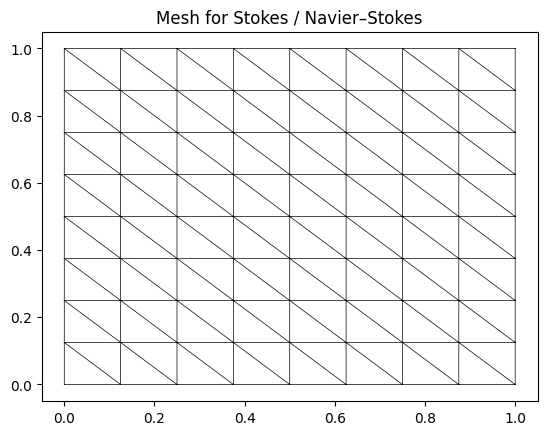

In [38]:
# 1. Создание сетки и визуализация
mesh = MeshTri().refined(3)
fig, ax = plt.subplots()
import skfem.visuals.matplotlib
skfem.visuals.matplotlib.draw(mesh, ax=ax)
ax.set_title("Mesh for Stokes / Navier–Stokes")
plt.show()

In [39]:
# 2. Определение элементов: Taylor–Hood (P2/P1)
# Basis для скорости (векторное поле) и давления (скаляр)
# Создаём базис скорости P2
basis_u = Basis(mesh, ElementTriP2())
# Создаём базис давления P1, но с той же квадратурой
basis_p = basis_u.with_element(ElementTriP1())


In [40]:
# 3. Слабая форма Stokes:
#   - ν ∇u : ∇v (внутри) + div(u) * q + div(v) * p = f·v
nu = 1.0

@BilinearForm
def a(u, v, w):
    return nu * dot(grad(u), grad(v))

@BilinearForm
def b(u, p, w):
    return - p * div(u)

@LinearForm
def l(v, w):
    # задаём нулевую правую часть (нет объёмных сил)
    return 0 * v

In [41]:

# Теперь можно собрать форму без ошибок:
A = asm(a, basis_u)
B = asm(b, basis_u, basis_p)
C = asm(b, basis_u, basis_p)  # транспонированная
f = asm(l, basis_u)

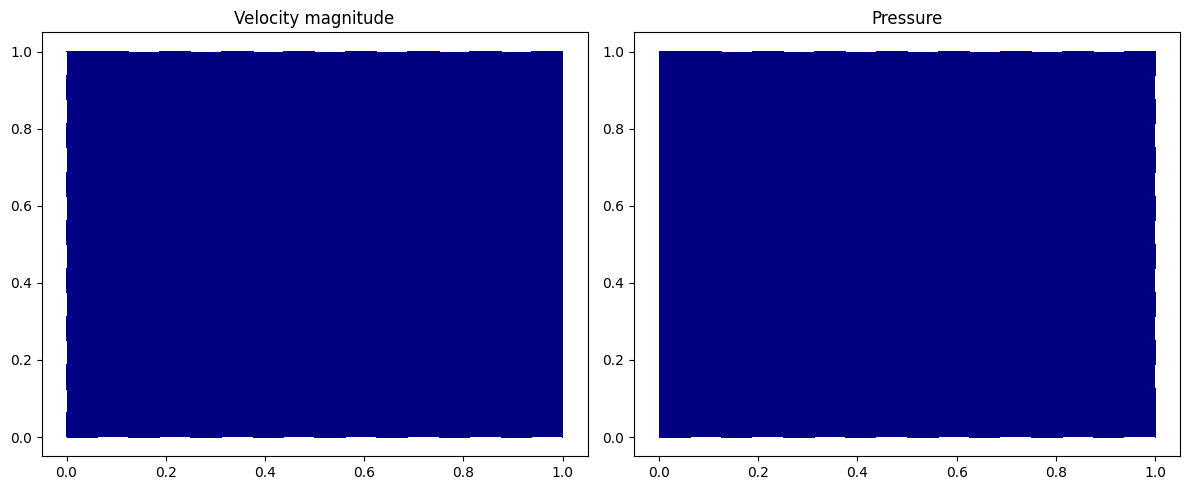

In [42]:

# 5. Построение и решение блочной системы:
# [ A  B.T ] [u] = [f]
# [ B   0  ] [p]   [0]
import scipy.sparse as sp
import scipy.sparse.linalg as spla

zero = sp.csr_matrix((basis_p.N, basis_p.N))
K = sp.bmat([[A, C.T], [B, zero]], format='csr')
rhs = np.concatenate([f, np.zeros(basis_p.N)])

up = spla.spsolve(K, rhs)
u = up[:basis_u.N]
p = up[basis_u.N:]

# 6. Визуализация: скорость и давление
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
skfem.visuals.matplotlib.plot(basis_u, u, ax=axes[0])
axes[0].set_title("Velocity magnitude")
skfem.visuals.matplotlib.plot(basis_p, p, ax=axes[1])
axes[1].set_title("Pressure")
plt.tight_layout()
plt.show()


In [3]:
import fenics as fe
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

N_POINTS_P_AXIS = 61

TIME_STEP_LENGTH = 0.01
N_TIME_STEPS = 1000
KINEMATIC_VISCOSITY = 0.01 # -> Re = 100 Чудеса начинаются с Re = 2300
                            # Однако уже при Re = 1000 программа перестает работать


mesh = fe.UnitSquareMesh(N_POINTS_P_AXIS, N_POINTS_P_AXIS)

# Taylor-Hood Elements. Степень многочленов для давления должна быть на 1 меньше
#степени многочленов для скорости
velocity_function_space = fe.VectorFunctionSpace(mesh, "Lagrange", 2)
pressure_function_space = fe.FunctionSpace(mesh, "Lagrange", 1)

u_trial = fe.TrialFunction(velocity_function_space)
p_trial = fe.TrialFunction(pressure_function_space)
v_test = fe.TestFunction(velocity_function_space)
q_test = fe.TestFunction(pressure_function_space)

# По бокам скорость равна 0. Сверху и снизу скорость равна 1. Граничные условия
stationary_wall_boundary_condition = fe.DirichletBC(
    velocity_function_space,
    (0.0, 0.0),
    """
    on_boundary && (x[0] < DOLFIN_EPS || x[0] > (1.0 - DOLFIN_EPS))
    """
)
moving_wall_boundary_condition = fe.DirichletBC(
    velocity_function_space,
    (1.0, 0.0),
    """
    on_boundary && (x[1] > (1.0 - DOLFIN_EPS) || x[1] < DOLFIN_EPS)
    """
)
velocity_boundary_conditions = [stationary_wall_boundary_condition, moving_wall_boundary_condition]


u_prev = fe.Function(velocity_function_space)
u_tent = fe.Function(velocity_function_space)
u_next = fe.Function(velocity_function_space)
p_next = fe.Function(pressure_function_space)

# Слабая форма для первого уравнения
momentum_weak_form_residuum = (
    1.0 / TIME_STEP_LENGTH * fe.inner(u_trial - u_prev, v_test) * fe.dx
    +
    fe.inner(fe.grad(u_prev) * u_prev, v_test) * fe.dx
    +
    KINEMATIC_VISCOSITY * fe.inner(fe.grad(u_trial), fe.grad(v_test)) * fe.dx
)
momentum_weak_form_lhs = fe.lhs(momentum_weak_form_residuum)
momentum_weak_form_rhs = fe.rhs(momentum_weak_form_residuum)

# Слабая форма для второго уравнения на давление
pressure_poisson_weak_form_lhs = fe.inner(fe.grad(p_trial), fe.grad(q_test)) * fe.dx
pressure_poisson_weak_form_rhs = - 1.0 / TIME_STEP_LENGTH * fe.div(u_tent) * q_test * fe.dx

# Слабая форма для последнего уравнения. Переход к новому слою.
velocity_update_weak_form_lhs = fe.inner(u_trial, v_test) * fe.dx
velocity_update_weak_form_rhs = (
    fe.inner(u_tent, v_test) * fe.dx
    -
    TIME_STEP_LENGTH * fe.inner(fe.grad(p_next), v_test) * fe.dx
)

# Магия для ускорения вычисление.
momentum_assembled_system_matrix = fe.assemble(momentum_weak_form_lhs)
pressure_poisson_assembled_system_matrix = fe.assemble(pressure_poisson_weak_form_lhs)
velocity_update_assembled_system_matrix = fe.assemble(velocity_update_weak_form_lhs)

for t in tqdm(range(N_TIME_STEPS)):
    # (1) Решение первого уравнения
    momentum_assembled_rhs = fe.assemble(momentum_weak_form_rhs)
    [bc.apply(momentum_assembled_system_matrix, momentum_assembled_rhs) for bc in velocity_boundary_conditions]
    fe.solve(
        momentum_assembled_system_matrix,
        u_tent.vector(),
        momentum_assembled_rhs,
        "gmres",
        "ilu",
    )

    # (2) Решение второго
    pressure_poisson_assembled_rhs = fe.assemble(pressure_poisson_weak_form_rhs)
    fe.solve(
        pressure_poisson_assembled_system_matrix,
        p_next.vector(),
        pressure_poisson_assembled_rhs,
        "gmres",
        "amg",
    )

    # (3) Решение третьего
    [bc.apply(momentum_assembled_system_matrix, momentum_assembled_rhs) for bc in velocity_boundary_conditions]
    velocity_update_assembled_rhs = fe.assemble(velocity_update_weak_form_rhs)
    fe.solve(
        velocity_update_assembled_system_matrix,
        u_next.vector(),
        velocity_update_assembled_rhs,
        "gmres",
        "ilu",
    )
    u_prev.assign(u_next)


100%|███████████████████████████████████████| 1000/1000 [01:23<00:00, 12.00it/s]


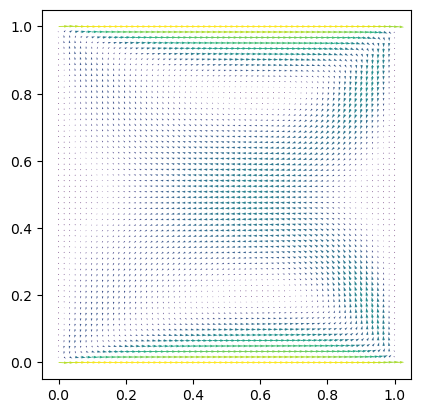

In [7]:
fe.plot(u_next)
plt.show()